<a href="https://colab.research.google.com/github/karegapauline/AQS_data_analysis/blob/main/methods_of_performce_analysis_reproducible_notes_and_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Methods of Performance Analysis**

# Prepared and presented by Pauline Karega for AQS EA

# Collocation studies: Comparing sensor data against reference-grade instruments

Why?

PM2.5 calibration is important because particulate matter composition and size distribution can vary based on a variety of factors, including local pollutant sources and environmental conditions.

NO2 measurements are also subject to influence from environmental conditions

Laboratory Testing: Used to identify system-to-system differences, as well as sensor-specific issues like hysteresis, drift, and cross-interference under controlled conditions.

Field Testing: Essential for a realistic evaluation of performance in the intended real-world environment, over weeks or months, to understand long-term behavior and the impact of actual environmental conditions.

 Calibration Techniques: Data from the sensor is compared with the reference instrument to develop calibration models, which can range from simple linear models to advanced non-linear machine learning models to account for complex environmental effects.


This presentation focuses on the data driven calibration techniques



Location: Nairobi, Kenya. Data will reflect typical patterns, including higher pollution during rush hours and lower levels at night, with some random "events."

Reference Monitor: Highly accurate, but with minimal, random noise.

Sensor: Has three types of error that are common in lower-cost sensors:

A Constant Bias (Offset): The sensor consistently reads 5 µg/m³ too high.

A Scaling Error (Gain): The sensor's response is not linear; it reads 10% higher than the actual concentration.

Random Noise: Higher random error at higher concentrations (heteroscedasticity).

A Non-Linear Effect: At very high concentrations, the sensor's performance degrades (saturates).


In [ ]:
## Generate synthetic data for 31 days

import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Create date range for May 2024 (31 days * 24 hours = 744 data points)
# Let's create a few more days to get exactly 1000 points.
dates = pd.date_range(start='2024-05-01', end='2024-06-12', freq='H')
n_points = len(dates)

# 1. Generate realistic base reference data with diurnal (daily) pattern
# Higher during day (6 AM - 10 PM), lower at night. Peaks during rush hours (7-9 AM, 5-7 PM).
hour_of_day = dates.hour
# Base pattern: low at night, high during day
base_pattern = 10 + 10 * np.sin(2 * np.pi * (hour_of_day - 6) / 24) # Min around 3 AM, max around 3 PM

# 2. Add weekday/weekend effect (lower on weekends)
day_of_week = dates.dayofweek
weekend_effect = np.where(day_of_week >= 5, -5, 0) # Saturday(5) and Sunday(6)

# 3. Add some random "events" (e.g., dust storms, increased traffic)
event_noise = np.zeros(n_points)
# Randomly choose 10 event periods
event_indices = np.random.choice(n_points, size=10, replace=False)
for idx in event_indices:
    event_duration = np.random.randint(3, 12) # Event lasts 3-12 hours
    event_magnitude = np.random.uniform(15, 40)
    for i in range(event_duration):
        if idx + i < n_points:
            event_noise[idx + i] = event_magnitude * np.exp(-i/4) # Exponential decay

# 4. Combine to create the "true" reference data
ref_pm25 = base_pattern + weekend_effect + event_noise
# Add very small random noise to the reference instrument (it's not perfect, but very good)
ref_pm25 += np.random.normal(0, 0.5, n_points)
# Ensure no negative values
ref_pm25 = np.maximum(0, ref_pm25)

# 5. Simulate the sensor readings with errors
sensor_pm25 = np.zeros(n_points)

for i, ref_val in enumerate(ref_pm25):
    # Sensor errors:
    bias = 5.0  # Constant bias (offset)
    gain = 1.1  # Scaling error (10% high)
    # Random noise, proportional to concentration (heteroscedasticity)
    random_error = np.random.normal(0, 0.5 + 0.1 * ref_val)

    # Basic sensor reading: (True value * gain) + bias + noise
    sensor_reading = (ref_val * gain) + bias + random_error

    # Non-linear error: Sensor saturates at high concentrations (e.g., > 75 µg/m³)
    if ref_val > 75:
        # As concentration increases above 75, the sensor reads progressively lower
        saturation_factor = max(0, 90 - ref_val) / 15  # Factor goes from 1 (at 75) to 0 (at 90+)
        sensor_reading = ref_val + (sensor_reading - ref_val) * saturation_factor

    sensor_pm25[i] = max(0, sensor_reading) # Ensure no negative values

# 6. Create DataFrame and save to CSV
df = pd.DataFrame({
    'timestamp': dates,
    'ref_pm25': np.round(ref_pm25, 1),
    'sensor_pm25': np.round(sensor_pm25, 1)
})

# Trim to first 1000 records
df = df.head(1000)

# Save to CSV
df.to_csv('nairobi_pm25_calibration_data.csv', index=False)

print("Synthetic dataset generated successfully!")
print(df.head(24)) # Print first 24 hours (one day) as a preview

Synthetic dataset generated successfully!
             timestamp  ref_pm25  sensor_pm25
0  2024-05-01 00:00:00       0.0          4.9
1  2024-05-01 01:00:00       0.3          5.3
2  2024-05-01 02:00:00       1.9          6.6
3  2024-05-01 03:00:00       3.1          6.4
4  2024-05-01 04:00:00       5.2         11.6
5  2024-05-01 05:00:00       7.2         13.8
6  2024-05-01 06:00:00       9.8         15.3
7  2024-05-01 07:00:00      12.4         18.7
8  2024-05-01 08:00:00      15.2         22.8
9  2024-05-01 09:00:00      16.9         20.1
10 2024-05-01 10:00:00      18.8         24.4
11 2024-05-01 11:00:00      20.7         29.8
12 2024-05-01 12:00:00      20.4         24.3
13 2024-05-01 13:00:00      19.5         27.2
14 2024-05-01 14:00:00      19.3         22.9
15 2024-05-01 15:00:00      16.9         24.6
16 2024-05-01 16:00:00      14.0         20.3
17 2024-05-01 17:00:00      12.1         15.5
18 2024-05-01 18:00:00       9.1         16.6
19 2024-05-01 19:00:00       7.2      

/tmp/ipython-input-3057684859.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2024-05-01', end='2024-06-12', freq='H')


In [ ]:
df.info()
time_range = df['timestamp'].min(), df['timestamp'].max()
time_range

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       1000 non-null   datetime64[ns]
 1   ref_pm25        1000 non-null   float64       
 2   sensor_pm25     1000 non-null   float64       
 3   error           1000 non-null   float64       
 4   absolute_error  1000 non-null   float64       
 5   squared_error   1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 47.0 KB


(Timestamp('2024-05-01 00:00:00'), Timestamp('2024-06-11 15:00:00'))

## 1. Descriptive statistics

Calculate mean, median, standard deviation for both reference and sensor.

Exercise: Compare the means. Is the sensor biased?

In [ ]:
## Descriptive statistics
print(df.describe()) ## for basic statistics


                           timestamp     ref_pm25  sensor_pm25
count                           1000  1000.000000  1000.000000
mean   2024-05-21 19:29:59.999999744     9.731900    15.738200
min              2024-05-01 00:00:00     0.000000     3.600000
25%              2024-05-11 09:45:00     2.000000     7.100000
50%              2024-05-21 19:30:00     9.400000    15.050000
75%              2024-06-01 05:15:00    15.425000    21.900000
max              2024-06-11 15:00:00    56.400000    73.000000
std                              NaN     8.375524     9.456701


## Measures of central tendency results
### Mean
Ref mean = 9.7319

Sensor mean = 15.7382

Diference = + 6.0063

Sensor concentrations are higher than reference monitor concentrations. Hence, a positive bias.

### Std deviation

Ref std dev = 8.375524

Sensor std dev = 9.456701

The sensor has greater variability than the ref grade monitor. Might be because of additional sensor noise, an increase or decrease of real variations.

### Note:

expect bias, new sensors typically have higher readings, and noise



In [ ]:
## MAE and RSME calculations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the dataset loaded as df
# df = pd.read_csv('nairobi_pm25_calibration_data.csv')

# Calculate errors
df['error'] = df['sensor_pm25'] - df['ref_pm25']
df['absolute_error'] = np.abs(df['error'])
df['squared_error'] = df['error'] ** 2

# Calculate metrics
mae = df['absolute_error'].mean()
rmse = np.sqrt(df['squared_error'].mean())
mean_bias = df['error'].mean()  # This is the actual bias
std_error = df['error'].std()   # Standard deviation of errors

print("=== SENSOR PERFORMANCE METRICS ===")
print(f"Mean Bias (MB): {mean_bias:.2f} µg/m³")
print(f"MAE (Mean Absolute Error): {mae:.2f} µg/m³")
print(f"RMSE (Root Mean Square Error): {rmse:.2f} µg/m³")
print(f"Standard Deviation of Errors: {std_error:.2f} µg/m³")
print(f"Sample Size: {len(df)} measurements")

=== SENSOR PERFORMANCE METRICS ===
Mean Bias (MB): 6.01 µg/m³
MAE (Mean Absolute Error): 6.01 µg/m³
RMSE (Root Mean Square Error): 6.32 µg/m³
Standard Deviation of Errors: 1.96 µg/m³
Sample Size: 1000 measurements


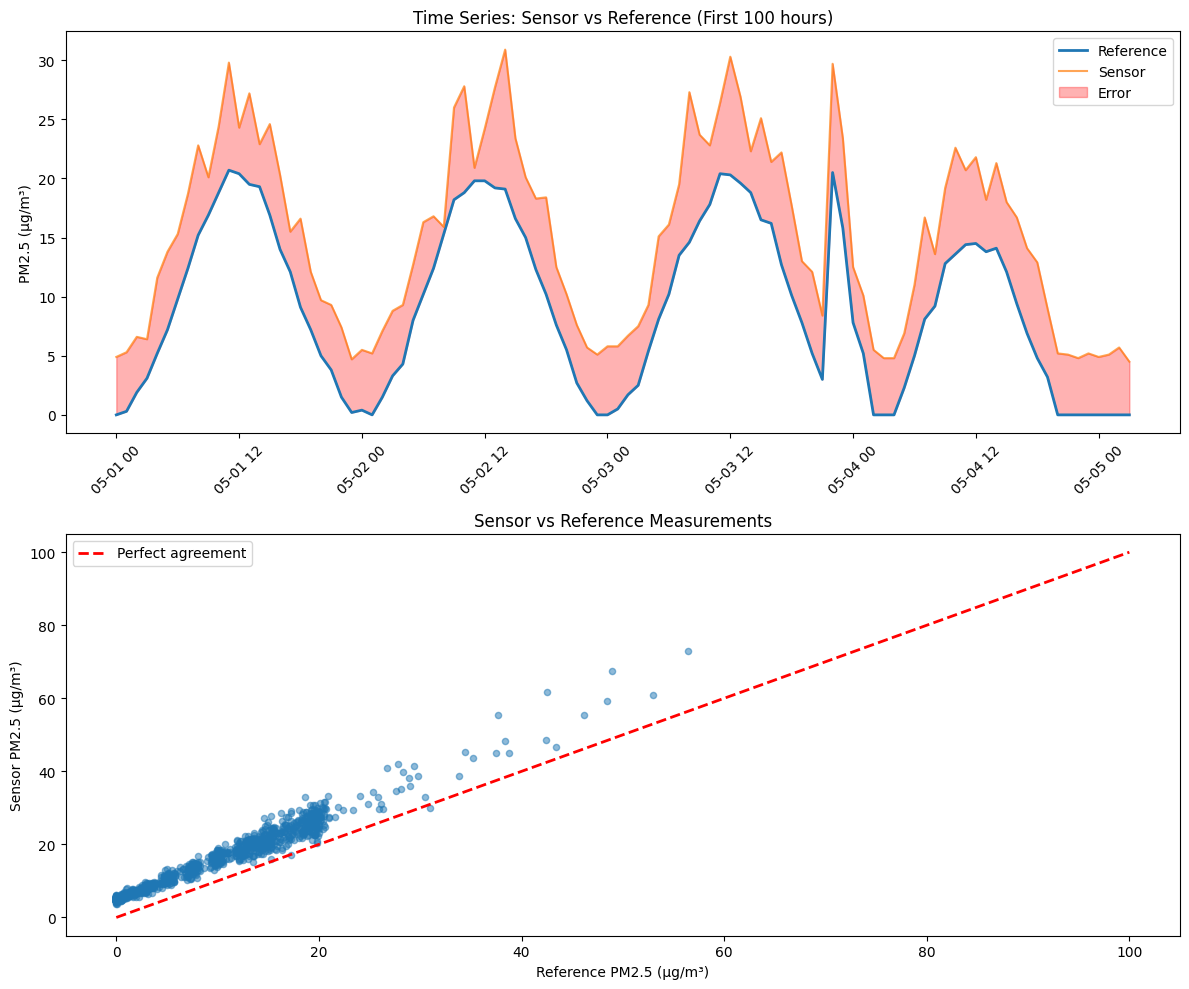

In [ ]:
# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 10)) # Create 2 subplots in a single column

# Plot 1: Time series showing bias
axes[0].plot(df['timestamp'][:100], df['ref_pm25'][:100], label='Reference', linewidth=2)
axes[0].plot(df['timestamp'][:100], df['sensor_pm25'][:100], label='Sensor', alpha=0.7)
axes[0].fill_between(df['timestamp'][:100], df['ref_pm25'][:100], df['sensor_pm25'][:100],
                      alpha=0.3, color='red', label='Error')
axes[0].set_title('Time Series: Sensor vs Reference (First 100 hours)')
axes[0].set_ylabel('PM2.5 (µg/m³)')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)


# Plot 2: Scatter plot with 1:1 line
axes[1].scatter(df['ref_pm25'], df['sensor_pm25'], alpha=0.5, s=20)
axes[1].plot([0, 100], [0, 100], 'r--', linewidth=2, label='Perfect agreement')
axes[1].set_xlabel('Reference PM2.5 (µg/m³)')
axes[1].set_ylabel('Sensor PM2.5 (µg/m³)')
axes[1].set_title('Sensor vs Reference Measurements')
axes[1].legend()



plt.tight_layout()
plt.show()

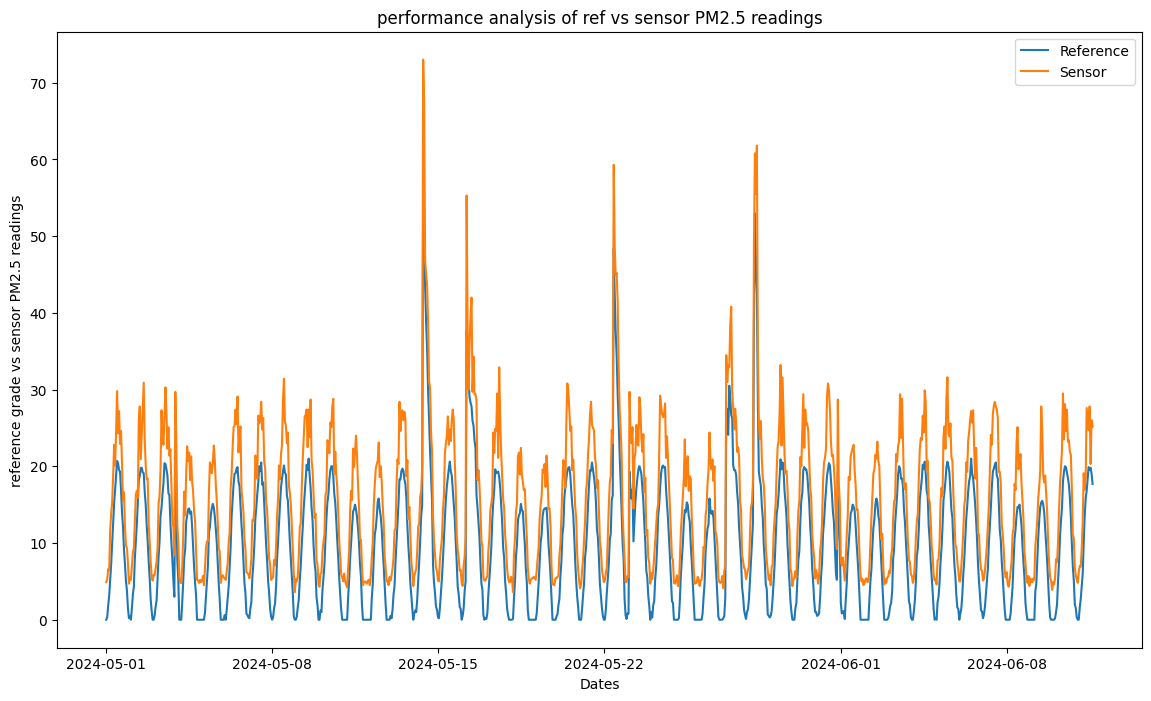

In [ ]:
## timeseries visualization of our data
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(df['timestamp'], df['ref_pm25'], label='Reference')
ax.plot(df['timestamp'], df['sensor_pm25'], label='Sensor')
ax.set_xlabel("Dates")
ax.set_ylabel("reference grade vs sensor PM2.5 readings")
ax.set_title("performance analysis of ref vs sensor PM2.5 readings")
ax.legend()
plt.show()

Sensor always reads higher than the reference monitor

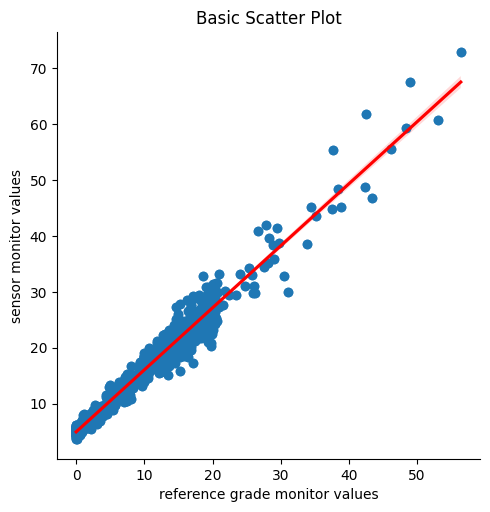

In [ ]:
## visualizing using scatter plots
reference_pm25 = df['ref_pm25']
sensor_pm25 = df['sensor_pm25']

sns.lmplot(x='ref_pm25', y='sensor_pm25', data=df, line_kws={'color': 'red'})

plt.scatter(reference_pm25, sensor_pm25)
plt.title("Basic Scatter Plot")
plt.xlabel("reference grade monitor values")
plt.ylabel("sensor monitor values")
plt.show()

References

https://zenodo.org/records/10836211

https://pmc.ncbi.nlm.nih.gov/articles/PMC11415614/


DOI	https://doi.org/10.1039/D3RA02408C

doi: 10.3390/s22031093




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def generate_realistic_calibration_data(n_points=1000):
    """
    Generate realistic TEOM vs sensor calibration data based on real calibration study patterns
    """
    np.random.seed(42)

    # Create timestamp series (hourly measurements over ~6 weeks)
    start_date = datetime(2024, 3, 1)
    dates = [start_date + timedelta(hours=i) for i in range(n_points)]

    # Generate realistic TEOM reference data based on real patterns
    # Real monitoring shows: diurnal patterns, weekday/weekend effects, pollution events
    hour_of_day = [d.hour for d in dates]
    day_of_week = [d.weekday() for d in dates]

    # Base pattern from real monitoring data (similar to the study)
    base_pattern = 8 + 12 * np.sin(2 * np.pi * (np.array(hour_of_day) - 6) / 24)

    # Weekday/weekend effect (higher on weekdays)
    weekday_effect = np.array([4 if d < 5 else -3 for d in day_of_week])  # Mon-Fri higher

    # Seasonal trend (slight increase over monitoring period)
    seasonal_trend = np.linspace(0, 3, n_points)

    # Pollution events (similar to real episodes)
    event_probability = 0.02
    event_noise = np.zeros(n_points)
    for i in range(n_points):
        if np.random.random() < event_probability:
            duration = np.random.randint(4, 48)  # 4-48 hour events
            magnitude = np.random.uniform(15, 60)
            for j in range(min(duration, n_points - i)):
                decay = np.exp(-j/8)  # Exponential decay
                event_noise[i + j] += magnitude * decay

    # Combine for TEOM reference data
    teom_pm25 = base_pattern + weekday_effect + seasonal_trend + event_noise
    teom_pm25 += np.random.normal(0, 1.5, n_points)  # Small reference instrument noise
    teom_pm25 = np.maximum(2, teom_pm25)  # Realistic minimum

    # Generate sensor data with realistic error patterns observed in calibration studies
    sensor_pm25 = np.zeros(n_points)

    for i, true_val in enumerate(teom_pm25):
        # Realistic error components based on the study:

        # 1. Non-linear response (common in optical sensors)
        if true_val < 20:
            gain = 1.15  # Over-response at low concentrations
        elif true_val < 50:
            gain = 1.05  # Better response in mid-range
        else:
            gain = 0.92  # Under-response at high concentrations (saturation)

        # 2. RH-dependent error (higher error at high humidity)
        rh_effect = 0.0
        hour = hour_of_day[i]
        if 4 <= hour <= 10:  # Morning humidity
            rh_effect = np.random.normal(3, 1)

        # 3. Temperature effect (worse performance at extremes)
        temp_effect = 0.0
        if hour <= 6 or hour >= 20:  # Cooler night hours
            temp_effect = np.random.normal(-1, 0.5)

        # 4. Sensor aging/drift (performance degrades over time)
        drift = (i / n_points) * 2  # Linear drift over monitoring period

        # 5. Heteroscedastic noise (more noise at higher concentrations)
        base_noise = np.random.normal(0, 0.5 + 0.08 * true_val)

        # Combine all effects
        sensor_reading = (true_val * gain) + rh_effect + temp_effect + drift + base_noise

        # Ensure realistic bounds
        sensor_pm25[i] = max(1, sensor_reading)

    # Add some sensor dropouts/missing data (common in real deployments)
    dropout_indices = np.random.choice(n_points, size=int(n_points*0.02), replace=False)
    for idx in dropout_indices:
        sensor_pm25[idx] = np.nan

    # Create DataFrame
    df = pd.DataFrame({
        'timestamp': dates,
        'teom_pm25': np.round(teom_pm25, 2),
        'sensor_pm25_raw': np.round(sensor_pm25, 2),
        'temperature_c': 15 + 10 * np.sin(2 * np.pi * (np.array(hour_of_day) - 6) / 24) + np.random.normal(0, 2, n_points),
        'relative_humidity': 50 + 30 * np.sin(2 * np.pi * (np.array(hour_of_day) - 3) / 24) + np.random.normal(0, 10, n_points)
    })

    return df

# Generate the dataset
df = generate_realistic_calibration_data(1000)

# Display first few rows
print("=== REALISTIC CALIBRATION DATASET (TEOM vs SENSOR) ===")
print(df.head(24))
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Basic statistics
print("\n=== DESCRIPTIVE STATISTICS ===")
print(df[['teom_pm25', 'sensor_pm25_raw']].describe())

=== REALISTIC CALIBRATION DATASET (TEOM vs SENSOR) ===
             timestamp  teom_pm25  sensor_pm25_raw  temperature_c  \
0  2024-03-01 00:00:00       2.04             1.00       3.385116   
1  2024-03-01 01:00:00       2.00             1.57       3.344831   
2  2024-03-01 02:00:00       3.65             3.98       4.574828   
3  2024-03-01 03:00:00       2.00             1.00       5.081791   
4  2024-03-01 04:00:00       8.03            12.74       8.417231   
5  2024-03-01 05:00:00      10.86            13.79      13.090681   
6  2024-03-01 06:00:00      13.37            18.82      18.592648   
7  2024-03-01 07:00:00      12.11            17.47      19.182155   
8  2024-03-01 08:00:00      19.55            22.16      21.272311   
9  2024-03-01 09:00:00      20.44            22.46      18.824001   
10 2024-03-01 10:00:00      18.63            28.60      23.898847   
11 2024-03-01 11:00:00      25.57            30.25      24.525338   
12 2024-03-01 12:00:00      26.20            28.

This training module was created based on synthetic data generated for Nairobi. It is based on the TEOM instrument.   

In [ ]:
def calculate_calibration_metrics(df):
    """Calculate comprehensive calibration metrics"""
    # Remove missing values for analysis
    analysis_df = df.dropna(subset=['sensor_pm25_raw'])

    teom = analysis_df['teom_pm25'].values
    sensor = analysis_df['sensor_pm25_raw'].values

    # Basic error metrics
    errors = sensor - teom
    mbe = np.mean(errors)  # Mean Bias Error
    mae = np.mean(np.abs(errors))  # Mean Absolute Error
    rmse = np.sqrt(np.mean(errors**2))  # Root Mean Square Error

    # Correlation and linear regression
    r_value = np.corrcoef(teom, sensor)[0, 1]
    slope, intercept = np.polyfit(teom, sensor, 1)

    # Performance metrics from the study
    r2 = r_value ** 2
    n = len(teom)

    print("=== CALIBRATION PERFORMANCE METRICS ===")
    print(f"Sample Size (n): {n}")
    print(f"Mean Bias Error (MBE): {mbe:.2f} µg/m³")
    print(f"Mean Absolute Error (MAE): {mae:.2f} µg/m³")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f} µg/m³")
    print(f"R² (Coefficient of Determination): {r2:.3f}")
    print(f"Correlation (r): {r_value:.3f}")
    print(f"Regression Slope: {slope:.3f}")
    print(f"Regression Intercept: {intercept:.3f}")

    # EPA performance targets (for context)
    print("\n=== EPA PERFORMANCE TARGETS (CONTEXT) ===")
    print("FEM (Federal Equivalent Method): R² ≥ 0.95, Slope = 1.00 ± 0.15")
    print("FRM (Federal Reference Method): Even stricter requirements")
    print("PurpleAir typically: R² ~ 0.80-0.95, Slope ~ 0.3-0.7 (raw)")

    return {
        'mbe': mbe, 'mae': mae, 'rmse': rmse,
        'r2': r2, 'slope': slope, 'intercept': intercept
    }

metrics = calculate_calibration_metrics(df)

=== CALIBRATION PERFORMANCE METRICS ===
Sample Size (n): 980
Mean Bias Error (MBE): 2.70 µg/m³
Mean Absolute Error (MAE): 3.15 µg/m³
Root Mean Square Error (RMSE): 4.04 µg/m³
R² (Coefficient of Determination): 0.955
Correlation (r): 0.977
Regression Slope: 1.022
Regression Intercept: 2.345

=== EPA PERFORMANCE TARGETS (CONTEXT) ===
FEM (Federal Equivalent Method): R² ≥ 0.95, Slope = 1.00 ± 0.15
FRM (Federal Reference Method): Even stricter requirements
PurpleAir typically: R² ~ 0.80-0.95, Slope ~ 0.3-0.7 (raw)


In [ ]:
def concentration_dependent_analysis(df):
    """Analyze performance across concentration ranges"""
    # Define concentration bins based on air quality categories
    bins = [0, 12, 35, 55, 150, 1000]
    labels = ['Good', 'Moderate', 'USG', 'Unhealthy', 'Very Unhealthy']

    df['aq_category'] = pd.cut(df['teom_pm25'], bins=bins, labels=labels)

    results = []
    for category in labels:
        cat_data = df[df['aq_category'] == category].dropna()
        if len(cat_data) > 10:  # Only analyze categories with sufficient data
            teom = cat_data['teom_pm25']
            sensor = cat_data['sensor_pm25_raw']
            errors = sensor - teom

            results.append({
                'Category': category,
                'n': len(cat_data),
                'TEOM_Mean': teom.mean(),
                'Sensor_Mean': sensor.mean(),
                'MBE': errors.mean(),
                'MAE': np.abs(errors).mean(),
                'RMSE': np.sqrt((errors**2).mean()),
                'R': np.corrcoef(teom, sensor)[0, 1] if len(teom) > 1 else np.nan
            })

    results_df = pd.DataFrame(results).round(3)
    print("\n=== CONCENTRATION-DEPENDENT PERFORMANCE ===")
    print(results_df)

    return results_df

conc_analysis = concentration_dependent_analysis(df)


=== CONCENTRATION-DEPENDENT PERFORMANCE ===
    Category    n  TEOM_Mean  Sensor_Mean    MBE    MAE   RMSE      R
0       Good  429      5.112        6.683  1.571  1.854  2.500  0.943
1   Moderate  479     20.342       24.178  3.836  4.034  4.731  0.866
2        USG   49     42.374       46.210  3.836  4.715  5.595  0.685
3  Unhealthy   23     67.830       65.407 -2.424  5.626  6.813  0.911



=== CONCENTRATION-DEPENDENT PERFORMANCE ===
    Category    n  TEOM_Mean  Sensor_Mean    MBE    MAE   RMSE      R
0       Good  429      5.112        6.683  1.571  1.854  2.500  0.943
1   Moderate  479     20.342       24.178  3.836  4.034  4.731  0.866
2        USG   49     42.374       46.210  3.836  4.715  5.595  0.685
3  Unhealthy   23     67.830       65.407 -2.424  5.626  6.813  0.911


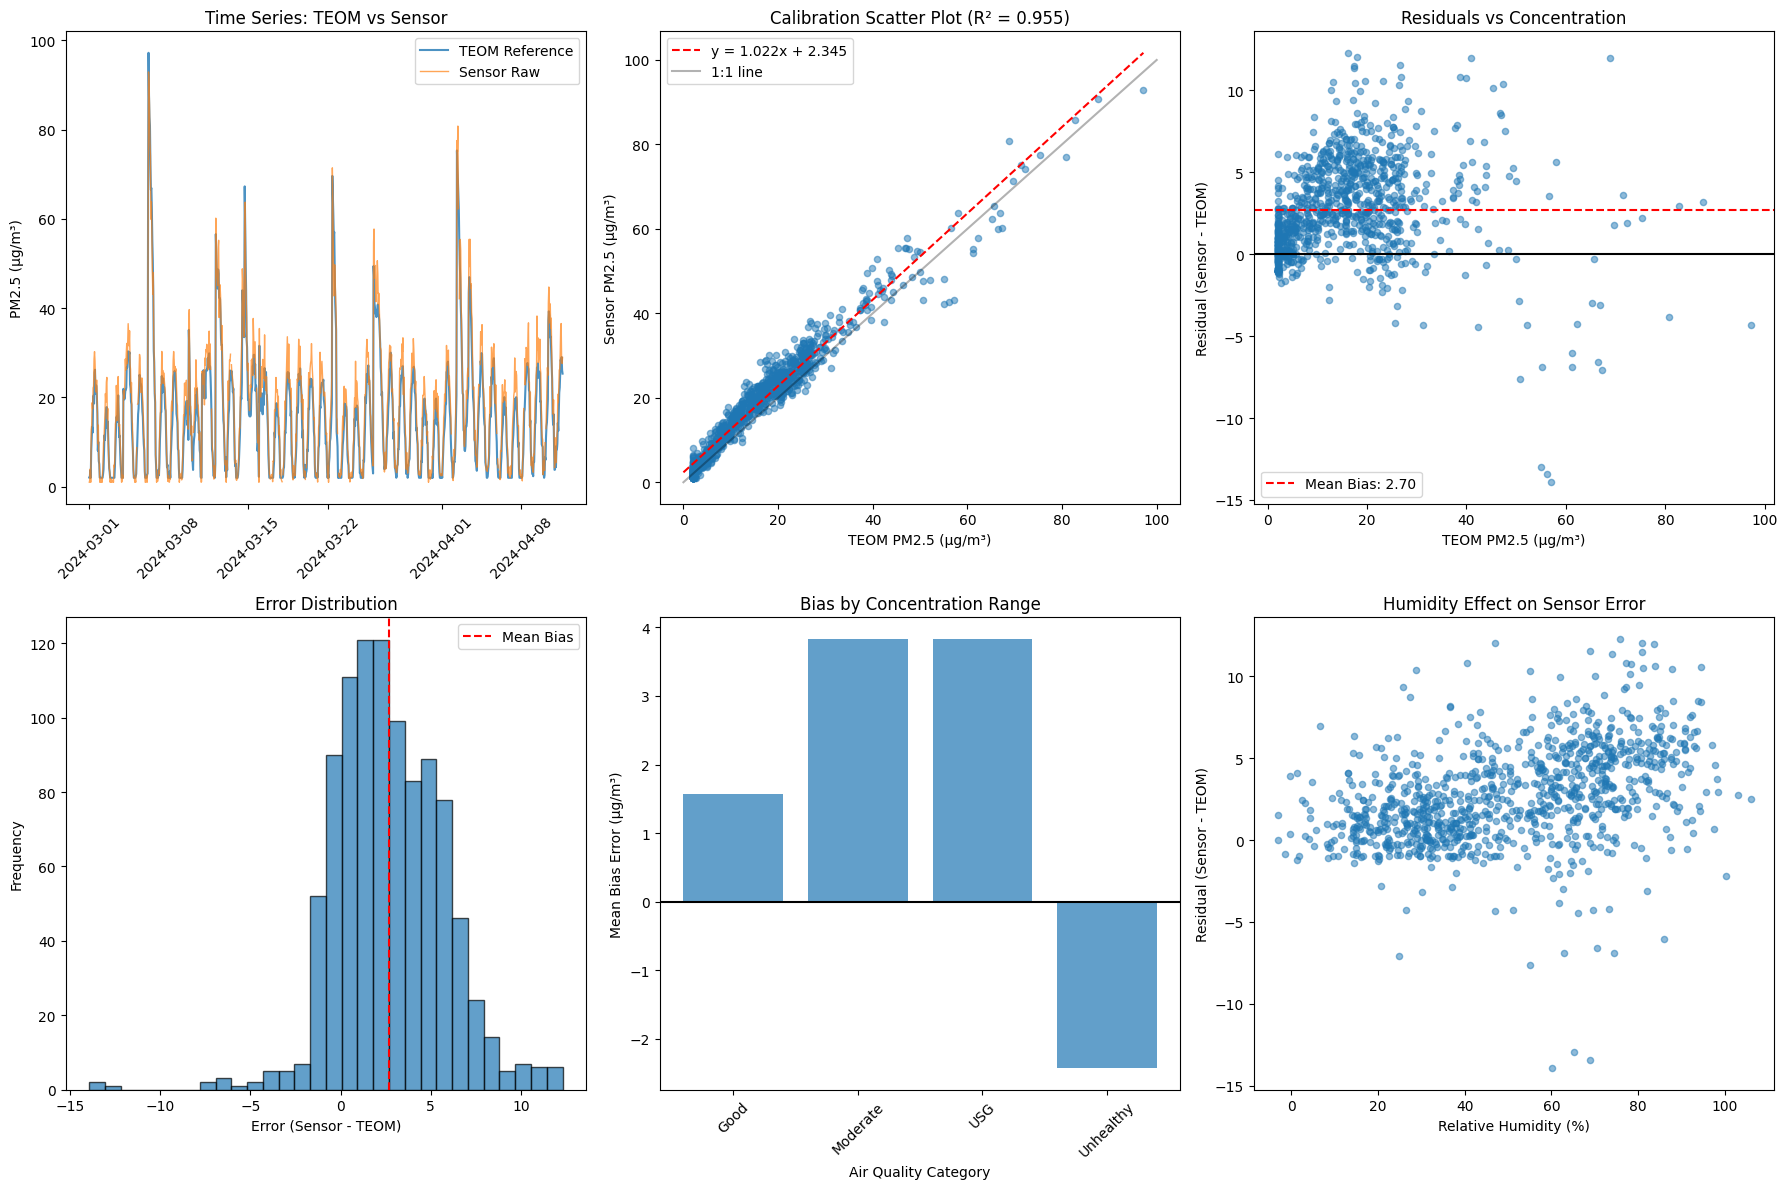

In [ ]:
def create_calibration_plots(df, metrics):
    """Create comprehensive calibration visualization"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Time series comparison
    axes[0,0].plot(df['timestamp'], df['teom_pm25'], label='TEOM Reference', linewidth=1.5, alpha=0.8)
    axes[0,0].plot(df['timestamp'], df['sensor_pm25_raw'], label='Sensor Raw', linewidth=1, alpha=0.7)
    axes[0,0].set_title('Time Series: TEOM vs Sensor')
    axes[0,0].set_ylabel('PM2.5 (µg/m³)')
    axes[0,0].legend()
    axes[0,0].tick_params(axis='x', rotation=45)

    # Plot 2: Scatter plot with regression
    valid_data = df.dropna(subset=['sensor_pm25_raw'])
    axes[0,1].scatter(valid_data['teom_pm25'], valid_data['sensor_pm25_raw'], alpha=0.5, s=20)
    x_range = np.linspace(0, valid_data['teom_pm25'].max(), 100)
    y_pred = metrics['slope'] * x_range + metrics['intercept']
    axes[0,1].plot(x_range, y_pred, 'r--', label=f'y = {metrics["slope"]:.3f}x + {metrics["intercept"]:.3f}')
    axes[0,1].plot([0, 100], [0, 100], 'k-', alpha=0.3, label='1:1 line')
    axes[0,1].set_xlabel('TEOM PM2.5 (µg/m³)')
    axes[0,1].set_ylabel('Sensor PM2.5 (µg/m³)')
    axes[0,1].set_title(f'Calibration Scatter Plot (R² = {metrics["r2"]:.3f})')
    axes[0,1].legend()

    # Plot 3: Residuals vs concentration
    residuals = valid_data['sensor_pm25_raw'] - valid_data['teom_pm25']
    axes[0,2].scatter(valid_data['teom_pm25'], residuals, alpha=0.5, s=20)
    axes[0,2].axhline(0, color='black', linestyle='-')
    axes[0,2].axhline(metrics['mbe'], color='red', linestyle='--', label=f'Mean Bias: {metrics["mbe"]:.2f}')
    axes[0,2].set_xlabel('TEOM PM2.5 (µg/m³)')
    axes[0,2].set_ylabel('Residual (Sensor - TEOM)')
    axes[0,2].set_title('Residuals vs Concentration')
    axes[0,2].legend()

    # Plot 4: Error distribution
    axes[1,0].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    axes[1,0].axvline(metrics['mbe'], color='red', linestyle='--', label=f'Mean Bias')
    axes[1,0].set_xlabel('Error (Sensor - TEOM)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Error Distribution')
    axes[1,0].legend()

    # Plot 5: Performance by concentration category
    conc_analysis = concentration_dependent_analysis(df)
    categories = conc_analysis['Category']
    mbe_values = conc_analysis['MBE']

    axes[1,1].bar(categories, mbe_values, alpha=0.7)
    axes[1,1].axhline(0, color='black', linestyle='-')
    axes[1,1].set_xlabel('Air Quality Category')
    axes[1,1].set_ylabel('Mean Bias Error (µg/m³)')
    axes[1,1].set_title('Bias by Concentration Range')
    axes[1,1].tick_params(axis='x', rotation=45)

    # Plot 6: RH effect on error
    # Ensure both sensor_pm25_raw and relative_humidity are not NaN for this plot
    rh_analysis_df = df.dropna(subset=['sensor_pm25_raw', 'relative_humidity'])
    residuals_rh = rh_analysis_df['sensor_pm25_raw'] - rh_analysis_df['teom_pm25']
    axes[1,2].scatter(rh_analysis_df['relative_humidity'], residuals_rh, alpha=0.5, s=20)
    axes[1,2].set_xlabel('Relative Humidity (%)')
    axes[1,2].set_ylabel('Residual (Sensor - TEOM)')
    axes[1,2].set_title('Humidity Effect on Sensor Error')

    plt.tight_layout()
    plt.show()

create_calibration_plots(df, metrics)

## YOUR RESULTS AND WHAT THEY MEAN

### R2

R² close to one indicates that both the reference instrument and the device under analysis detect changes in pollutant concentration at the same time and with the same relative magnitude. If we plot the time series of the measurements from both devices, we will see the lines following the same high-low trend. If we plot the measurements from the device under analysis versus the measurements of the reference instrument in a scatter plot, the points will be arranged approximately on a line.

R² close to zero indicates that when the reference instrument detects a change in pollutant concentration, the device under analysis does not, or vice versa when the reference instrument shows no change in pollutant concentration, the device under analysis measures a change. If we plot the time series of the measurements from both devices, we will see the lines following different trends with no apparent agreement. If we plot the measurements from the device under analysis versus the measurements of the reference instrument in a scatter plot, the points will be arranged in a random fashion.



## This part insists the need to use multiple techniques at a time and not rely on just one
